In [29]:
import numpy as np
import math
import os
import time
import re
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import imread
from scipy.signal import fftconvolve
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

from skimage import data, img_as_float

from PIL import Image

from correlation import *

In [60]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    print('Reading multi-tiff file')
 
    img = Image.open(path)
    #images = np.array()
    images = []
    for i in range(n_images):
        try:
            img.seek(i)

            #np.stack(images, np.array(img))
            images.append(np.array(img))

        except EOFError:
            # Not enough frames in img
            break
    print('Finished reading')

    return np.array(images)

def scan_directory_tree(rootDir):
    
    path_list = []
    
    print('Start scanning')
    # Set the directory you want to start from
    #rootDir = u'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\'
    for dirName, subdirList, fileList in os.walk(rootDir):
        
        final_dir = (dirName.split('\\')[-1:][0])
        
        # Find Z**Y** pattern as final folders containing .cine files
        is_valid = re.search('^([Z][0-9.]+[Y][0-9.]+)', final_dir)
        #is_valid = True
         
        if is_valid:
            #path_list.append(dirName)
            #print('Dir: %s' % dirName)
            
            for fname in fileList:
                if fname.find('.cine') != -1:
                    #print('\t%s' % fname)
                    path = os.path.join(dirName, fname)
                    path_list.append(path)
                    #print('%s' % path)

    print ('End scanning')
    print ('In total', len(path_list), 'datasets')
    return path_list
    
def update_slice(images_list, sliceN):
    plt.imshow(images_list[sliceN], cmap=cm.gray)
    #plt.colorbar()
    plt.show()

def make_dir(path):

    try:  
        os.makedirs(path)
        
    except OSError:
        pass
        #print('')
        #print ("Creation of the directory %s failed" % path)

def compute_fake(image):
    
    from skimage.morphology import square, dilation
    
    data = []
    
    for x in range(5):
        noise = random_noise(image,  mode='gaussian', var=0.1)
        #noise = np.zeros_like(image)

        for i in range(10):
            speckle = random_noise(np.zeros_like(image), mode='s&p', amount=0.01)       

            m = random.randint(1, 5)
            holes = dilation(speckle, square(m))

            noise = noise - holes
            noise[noise < 0] = 0
        
        data.append(noise)
    
    return data[0], data[1], data[2], data[3], data[4]
    
    

In [53]:
frame = 65

# top directory for processing results
path_proc = 'proc/'

path_raw = path_proc +    'raw/'
path_input = path_proc +  'input/'
path_amp = path_proc +    'amp/'
path_flow_x = path_proc + 'flow_x/'
path_flow_y = path_proc + 'flow_y/'
path_corr = path_proc +   'corr/'


In [60]:
import pickle
#with open('datasets_list', 'wb') as fp:
#    pickle.dump(datasets_path_file_list, fp)
    
# Read prepared dataset list    
with open ('datasets_list', 'rb') as fp:
    datasets_path_file_list = pickle.load(fp)
    
print(datasets_path_file_list)

[('y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 11.3 auf 12.3\\025_1\\Ansicht 0°\\OP_1bar_25°C_100bar_25°C\\Z0Y0', 'OP_1bar_25C_100bar_25C.tif'), ('y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 09.3 auf 10.3\\023_1\\Ansicht 0°\\OP_1bar_25°C_100bar_25°C\\Z0Y0', 'OP_1bar_25C_100bar_25C.tif')]


Data path: /Users/aleksejersov/data/spray/0_25/
Data file name: test.tif 

Reading multi-tiff file
Finished reading
Time elapsed:  0.5308957099914551
OK
[3, 100]
[10, 150]
Durations [ 7 50]

Processing frames:
3 4 5 6 7 8 9 

Making summary


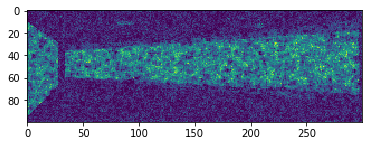

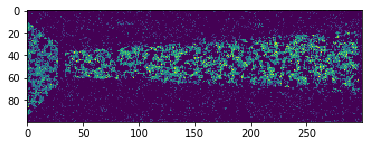

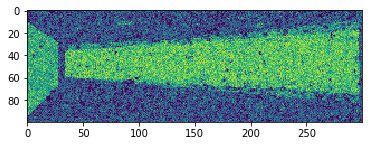

In [80]:
#datasets_path_file_list = [('/Users/aleksejersov/data/spray/0_25', 'test.tif')]

#----------------------------------------
# Select dataset for processing
#----------------------------------------
for dataset in datasets_path_file_list:
  
    path = dataset[0] + '/'
    file_name = dataset[1]

    print('Data path:', path)
    print('Data file name:', file_name, '\n')

    max_read_images = 10    

    # Read dataset
    start = time()
    images = read_tiff(path + file_name, max_read_images)
    end = time()

    print ('Time elapsed: ', (end-start))

    # Make analysis directories
    make_dir(path + path_raw)
    make_dir(path + path_input)
    make_dir(path + path_amp)
    make_dir(path + path_flow_x)
    make_dir(path + path_flow_y)
    make_dir(path + path_corr)


    # Analyze frames inside a dataset, get events starting and ending points as frame numbers
    start_indexes = [3, 100]
    end_indexes = [10, 150]
    # !!!!!!!!!!!!! ---- REAL COMPUTATION ------ !!!!!!!!!!!!!!!
    #start_indexes, end_indexes = get_spraying_events(images, max_read_images, sigma=15, min_brigthness=15, range_diff_value=0.3)

    print('OK')
    print(start_indexes)
    print(end_indexes)
    print('Durations', np.array(end_indexes) - np.array(start_indexes))


    # Preview data
    #print(images.shape)
    #value = start_indexes[0]
    #interact(update_slice, images_list=fixed(images), sliceN=widgets.IntSlider(min=0,max=len(images)-1,step=1,value=value));


    # Arrays to store the integrated results
    image_shape = images[0].shape
    #amp_res_list = np.empty(image_shape)
    amp_res_list = []
    corr_res_list = np.empty(image_shape)
    flow_x_res_list = np.empty(image_shape)
    flow_y_res_list = np.empty(image_shape)

    #---------------------------------------------------
    # For all spraying events inside a single dataset
    #---------------------------------------------------
    #for spray_event_num in range(len(start_indexes)):
    for spray_event_num in range(1):

        # current sequence event
        seq_num = 0

        # Flat field correction

        # get flats (first frame indicated by start_indexes)
        flats = images[0: start_indexes[spray_event_num]-1]

        # average flats
        flat = np.mean(flats, axis=0)
        
        im_res = Image.fromarray(flat)
        im_res.save(path + path_proc + 'flat.tif')

        #print('Flat field')
        #plt.imshow(flat, cmap='gray')
        #plt.show()

        start = start_indexes[spray_event_num]
        end = end_indexes[spray_event_num]
        every_nth_image = 1 

        #---------------------------------------------------
        # Process image frames
        #---------------------------------------------------
        print('\nProcessing frames:')
        
        for i in range(start, end, every_nth_image):

            frame = i
            
            print(str(frame), end=" ")
            
            # Get current image frame
            raw = images[frame]       
            im_res = Image.fromarray(raw)
            im_res.save(path + path_raw + str(frame).zfill(4) + '_orig_raw.tif')

            # Flat correction
            im = np.log((flat.astype(float)  + 0.001) / (raw.astype(float)  + 0.001))
            im_res = Image.fromarray(im)
            im_res.save(path + path_input + str(frame).zfill(4) + '_flat_corr.tif')

            #-----------------------------
            # Compute correlation
            #-----------------------------

            window_size = 30

            # Crop frame
            xmin = 290
            xmax = 975
            ymin = 150
            ymax = 350

            #plt.imshow(im[ymin:ymax, xmin:xmax], vmin=-0.5, vmax=0.5, cmap='gray')
            #plt.show()


            # Compute cropped region
            amp, vx, vy, errors, corr = compute_fake(raw)
            # !!!!!!!!!!!!! ---- REAL COMPUTATION ------ !!!!!!!!!!!!!!!
            #amp, vx, vy, errors, corr = compute_flow_area(im, window_size, xmin, xmax, ymin, ymax)

            # Collect results
            #amp_res_list = np.stack((amp_res_list, amp), axis=0)
            amp_res_list.append(amp)
            #corr_res_list = np.stack((corr_res_list, corr), axis=0)
            #flow_x_res_list = np.stack((flow_x_res_list, vx), axis=0)
            #flow_y_res_list = np.stack((flow_y_res_list, vy), axis=0)

            # Save results
            im_res = Image.fromarray(amp)
            im_res.save(path + path_amp + str(frame).zfill(4) +'_res_amp.tif')

            im_res = Image.fromarray(vx)
            im_res.save(path + path_flow_x + str(frame).zfill(4) +'_res_flow_x.tif')

            im_res = Image.fromarray(vy)
            im_res.save(path + path_flow_y + str(frame).zfill(4) +'_res_flow_y.tif')

            im_res = Image.fromarray(corr)
            im_res.save(path + path_corr + str(frame).zfill(4) +'_res_corr.tif')


    # Make summary statistics
    if make_summary = False
    
    if make_summary:
        print('\n\nMaking summary')

        amp_res_list = np.array(amp_res_list)

        amp_mean = np.mean(amp_res_list, axis=0)  
        plt.imshow(amp_mean)
        plt.show()
        im_res = Image.fromarray(amp_mean)
        im_res.save(path + path_proc + 'amp_mean.tif')

        amp_median = np.median(amp_res_list, axis=0)  
        plt.imshow(amp_median)
        plt.show()
        im_res = Image.fromarray(amp_median)
        im_res.save(path + path_proc + 'amp_median.tif')

        amp_std = np.std(amp_res_list, axis=0)  
        plt.imshow(amp_std)
        plt.show()
        im_res = Image.fromarray(amp_std)
        im_res.save(path + path_proc + 'amp_std.tif')
              
            
    print('\n\n')

    